In [12]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [13]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime, timedelta

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy.orm import sessionmaker

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
# reflect the tables
Base = automap_base()
Base.prepare(engine, reflect=True)
#print(Base.classes.keys())
Station = Base.classes.station
Measurement = Base.classes.measurement
session = Session(engine)



/var/folders/vw/4kkg803j2lb34mn5dv30l39h0000gn/T/ipykernel_2565/2366511194.py:4: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [6]:
# View all of the classes that automap found
print(Base.classes.keys())

['station', 'measurement']


In [7]:
# Save references to each table
all_stations = session.query(Station.name).all()
for station in all_stations:
    print(station.name)
session.close()    

WAIKIKI 717.2, HI US
KANEOHE 838.1, HI US
KUALOA RANCH HEADQUARTERS 886.9, HI US
PEARL CITY, HI US
UPPER WAHIAWA 874.3, HI US
WAIMANALO EXPERIMENTAL FARM, HI US
WAIHEE 837.5, HI US
HONOLULU OBSERVATORY 702.2, HI US
MANOA LYON ARBO 785.2, HI US


In [8]:
# Create our session (link) from Python to the DB
Session = sessionmaker(bind=engine)
session = Session()

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()

print(f"Most Recent Date: {most_recent_date}")

Most Recent Date: 2017-08-23


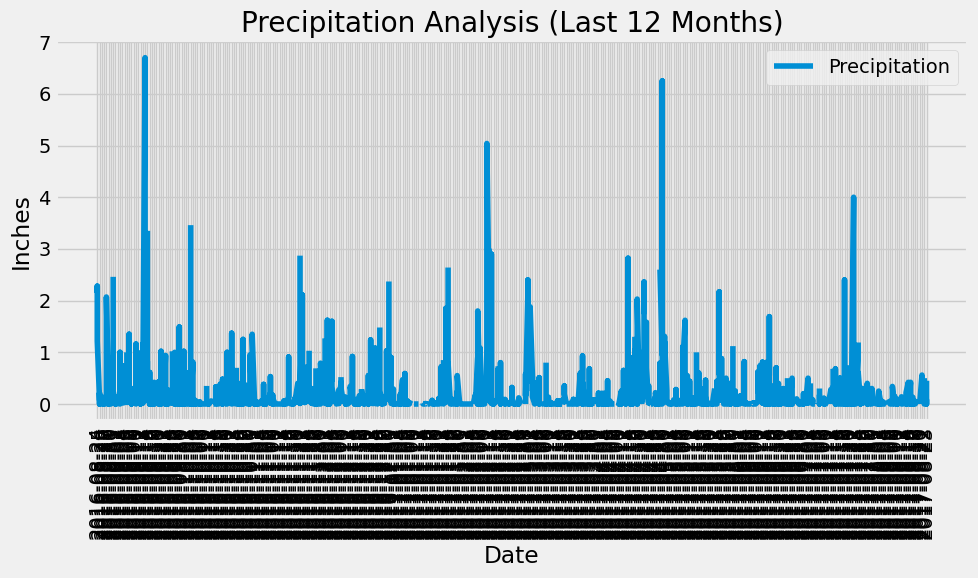

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()
most_recent_date = datetime .strptime(most_recent_date, '%Y-%m-%d')
one_year_ago = most_recent_date - timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
sel = [Measurement.date, Measurement.prcp]
query_result = session.query(*sel).filter(Measurement.date >= one_year_ago).all()


# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(query_result, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
df.sort_values('Date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Precipitation'], label='Precipitation')
plt.xlabel('Date')
plt.ylabel('Inches')
plt.title('Precipitation Analysis (Last 12 Months)')
plt.legend(loc='upper right')
plt.xticks(rotation='vertical')
plt.tight_layout()
plt.show()

In [20]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = df['Precipitation'].describe()

print(summary_statistics)

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64


# Exploratory Station Analysis

In [21]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(Station).count()

print(f"Total number of stations: {total_stations}")


Total number of stations: 9


In [22]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = session.query(
    Measurement.station, 
    func.count(Measurement.station)
).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
for station, count in most_active_stations:
    print(f"Station {station} has {count} observations")

Station USC00519281 has 2772 observations
Station USC00519397 has 2724 observations
Station USC00513117 has 2709 observations
Station USC00519523 has 2669 observations
Station USC00516128 has 2612 observations
Station USC00514830 has 2202 observations
Station USC00511918 has 1979 observations
Station USC00517948 has 1372 observations
Station USC00518838 has 511 observations


In [23]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = most_active_stations[0][0]
temperature_stats = session.query(
    func.min(Measurement.tobs),
    func.max(Measurement.tobs),
    func.avg(Measurement.tobs)
).filter(Measurement.station == most_active_station_id).all()
lowest_temp, highest_temp, avg_temp = temperature_stats[0]

print(f"Lowest Temperature: {lowest_temp}")
print(f"Highest Temperature: {highest_temp}")
print(f"Average Temperature: {round(avg_temp, 2)}")

Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66


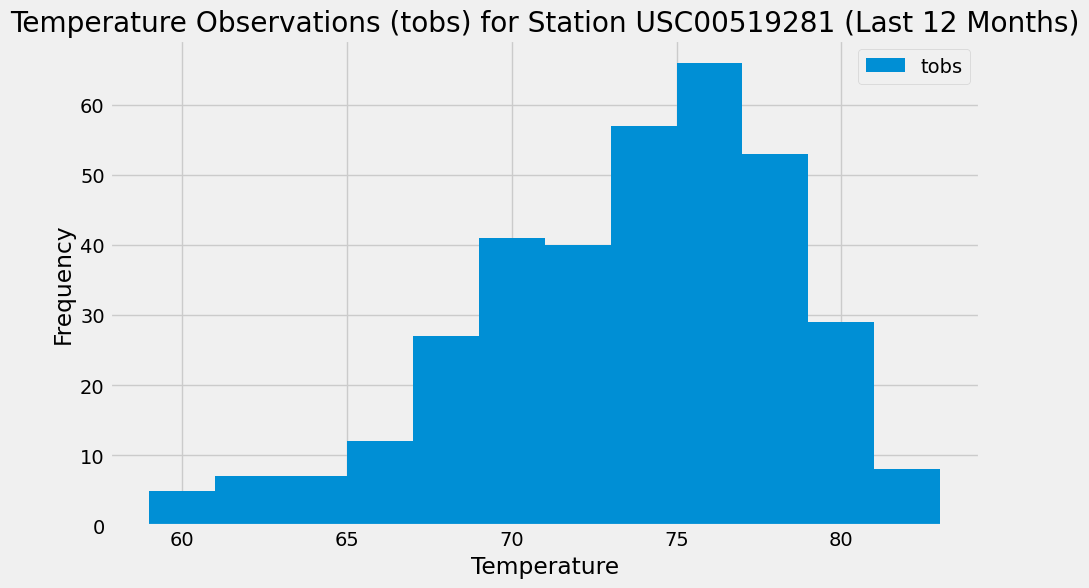

In [25]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
one_year_ago_date = most_recent_date - timedelta(days=365)

temperature_observations = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active_station_id).\
    filter(Measurement.date >= one_year_ago_date.strftime('%Y-%m-%d')).all()
temperatures = [temp[0] for temp in temperature_observations]
plt.figure(figsize=(10, 6))
plt.hist(temperatures, bins=12, label='tobs')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title(f"Temperature Observations (tobs) for Station {most_active_station_id} (Last 12 Months)")
plt.legend()
plt.show()

# Close Session

In [26]:
# Close Session
session.close()